<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/Artificial_General_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Ashem vohu vahishtem asti ushta asti ushta ahmai yad ashai vahishtai ashem
#copyright joshuah.rainstar@gmail.com 2025
#some concepts borrowed from various papers.
#add_hypersphere_phase_heads by me.
#use my code and my ideas- but if you have money, I want some. I need a new car and a house.

from __future__ import annotations
import math
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass



class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


def add_hypersphere_phase_heads(x: torch.Tensor, num_segs: int, eps: float = 1e-8) -> torch.Tensor:
    """
    x: [B,T,C]
    num_segs: number of segments to divide C dimension into
    First segment gets no phase info, subsequent segments get lag 1, 2, 3, etc.
    """
    B, T, C = x.shape
    if T == 0 or num_segs <= 0:
        return x

    assert C % num_segs == 0, f"C ({C}) must be divisible by num_segs ({num_segs})"
    seg_size = C // num_segs

    # Reshape to treat segments as separate heads: [B,T,C] -> [B,num_segs,T,seg_size]
    x_reshaped = x.view(B, T, num_segs, seg_size).transpose(1, 2)  # [B,num_segs,T,seg_size]

    # Skip first segment, process segments 1 onwards with lags 1, 2, 3, ...
    if num_segs > 1:
        # Create lags: [1, 2, 3, ..., num_segs-1] for segments 1, 2, 3, ..., num_segs-1
        L_h = torch.arange(1, num_segs, device=x.device, dtype=torch.long)  # [num_segs-1]

        # Process only segments 1 onwards
        x_to_process = x_reshaped[:, 1:]  # [B, num_segs-1, T, seg_size]

        v = F.normalize(x_to_process, dim=-1, eps=eps)  # [B,num_segs-1,T,seg_size]

        t = torch.arange(T, device=x.device)  # [T]
        src = (t.unsqueeze(0) - L_h.view(-1, 1)).clamp_min(0)  # [num_segs-1,T]

        # gather anchors per segment and time
        anchor = v.gather(
            dim=2,
            index=src.view(1, num_segs-1, T, 1).expand(B, num_segs-1, T, seg_size)
        )
        cosA = (v * anchor).sum(dim=-1).clamp(-1.0 + eps, 1.0 - eps)  # [B,num_segs-1,T]
        scalar = (cosA / max(seg_size, 1)).unsqueeze(-1)  # [B,num_segs-1,T,1]

        # Add scalar to processed segments
        x_modified = x_to_process + scalar  # [B,num_segs-1,T,seg_size]

        # Combine unchanged first segment with modified segments
        x_reshaped = torch.cat([x_reshaped[:, :1], x_modified], dim=1)  # [B,num_segs,T,seg_size]

    # Reshape back to original format: [B,num_segs,T,seg_size] -> [B,T,C]
    return x_reshaped.transpose(1, 2).contiguous().view(B, T, C)


class KalmanSweepMHGainsOptimal(nn.Module):
    """
    Optimal form with:
    - Sink mechanism via adaptive R
    - Shared V: first chunk broadcast to all heads
    - Fused operations for efficiency
    """
    def __init__(self, cfg, n_passes: int = 12, init_logQ: float = -2.0, eps: float = 1e-6):
        super().__init__()
        self.n_embd = cfg.n_embd
        self.n_head = cfg.n_head
        self.dh = cfg.n_embd // cfg.n_head
        self.n_passes = n_passes
        self.eps = eps

        # Single fused projection for all operations
        # Now outputs 5 components: [H_diag, y, R_diag, A_modulation, sink_gate]
        self.fused_proj = nn.Linear(3 * self.dh, 5 * self.dh)

        # Base transition (can be modulated)
        self.A_base = nn.Parameter(torch.eye(self.dh))

        # Process noise
        self.logQ = nn.Parameter(torch.full((self.n_head, self.dh), init_logQ))

        # Scales
        self.scales = nn.Parameter(torch.ones(3, self.n_head))  # H_scale, R_scale, sink_scale

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
        B, N, D = Q.shape
        H, dh = self.n_head, self.dh

        # Extract first chunk of V and broadcast to all heads
        V_reshaped = V.view(B, N, H, dh)  # [B, N, H, dh]
        V_shared = V_reshaped[:, :, 0:1, :].expand(B, N, H, dh)  # Broadcast first head to all
        V_broadcast = V_shared.contiguous().view(B, N, D)  # [B, N, D]

        # Use original Q, K but shared V for projection
        QKV = torch.cat([Q, K, V_broadcast], dim=-1).view(B * N * H, 3 * dh)

        # Fused projection and activation
        out = self.fused_proj(QKV).view(B, N, H, 5 * dh)
        H_raw, y, R_raw, A_mod, sink_raw = out.chunk(5, dim=-1)

        # Apply activations and scales
        H_diag = torch.sigmoid(H_raw) * self.scales[0].view(1, 1, H, 1)

        # Sink mechanism: when sink_gate → 0, R → ∞ (ignore input)
        sink_gate = torch.sigmoid(sink_raw) * self.scales[2].view(1, 1, H, 1)
        R_base = F.softplus(R_raw) * self.scales[1].view(1, 1, H, 1) + self.eps
        R_diag = R_base / (sink_gate + 0.01)  # When sink_gate→0, R becomes very large

        # Modulated transition matrix
        A_mod_sigmoid = torch.sigmoid(A_mod).view(B * N * H, dh, 1)
        A = self.A_base.unsqueeze(0) * A_mod_sigmoid  # (B*N*H, dh, dh)

        # Pre-compute constants
        Q_diag = torch.exp(self.logQ).clamp(min=self.eps).view(1, 1, H, dh)

        # Initialize with cold start
        P = torch.ones(B, N, H, dh, device=Q.device)
        HP = H_diag * P
        S = HP * H_diag + R_diag
        K_gain = HP / S

        if self.n_passes == 1:
            return K_gain.reshape(B, N, D)

        # State for multi-pass
        x = K_gain * y
        P = P - K_gain * HP

        # Parallel passes
        for pass_idx in range(1, self.n_passes):
            # Shift and transform in one operation
            x_flat = x[:, :-1].reshape(B * (N-1) * H, dh)
            x_pred_flat = torch.bmm(
                A[:B*(N-1)*H].view(B*(N-1)*H, dh, dh),
                x_flat.unsqueeze(-1)
            ).squeeze(-1).view(B, N-1, H, dh)

            x_prev = torch.cat([
                torch.zeros(B, 1, H, dh, device=x.device),
                x_pred_flat
            ], dim=1)

            P_prev = torch.cat([
                torch.ones(B, 1, H, dh, device=P.device),
                P[:, :-1] + Q_diag
            ], dim=1)

            # Parallel Kalman update
            HP = H_diag * P_prev
            S = HP * H_diag + R_diag
            K_gain = HP / S

            innov = y - H_diag * x_prev
            x = x_prev + K_gain * innov
            P = P_prev - K_gain * HP

        return K_gain.reshape(B, N, D)






# ------------------------------------------------------------------- DynMix --
class DynMix(nn.Module):
    """
    Symplectic mixer for ≥3 tensors (B,T,E).  See original author for details.
    """

    def __init__(self, step: float = 0.1):
        super().__init__()
        self.h = float(step)

    @staticmethod
    def _coop(R: torch.Tensor, C: torch.Tensor, h: float) -> torch.Tensor:
        w = torch.sigmoid((R * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        k1 = w * (C - R)
        k2 = w * (C - (R + h * k1))
        return R + 0.5 * h * (k1 + k2)

    @staticmethod
    def _mix_list(xs: List[torch.Tensor], h: float) -> List[torch.Tensor]:
        n = len(xs)
        if n < 3:
            raise ValueError("Need at least 3 components")
        stacked = torch.stack(xs, 0)
        total = stacked.sum(0, keepdim=False)
        out = []
        for i in range(n):
            others_mean = (total - stacked[i]) / (n - 1)
            out.append(DynMix._coop(stacked[i], others_mean, h))
        return out

    def forward(self, comps: List[torch.Tensor], loop_iters: int = 2) -> List[torch.Tensor]:
        for _ in range(loop_iters):
            comps = DynMix._mix_list(comps, self.h)
        return comps



class CausalKalman(nn.Module):
    def __init__(self, config):
        super().__init__()

        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.cal = KalmanSweepMHGainsOptimal(cfg=config)
        self.dynmix = DynMix()

        self.n_head = config.n_head
        self.n_embd = config.n_embd

        self.head_dim = config.n_embd // config.n_head

    def forward(self, x):
        B, T, C = x.size()

        # QKV projection
        qkv = self.c_attn(x)  # [B, T, 3*C]
        q, k, v = qkv.split(self.n_embd, dim=2)
        s = [q,k,v]
        s = self.dynmix(s) #apply mixing
        q, k, v = s
        s = self.cal(q,k,v)

        return x*s



class RotaryPositionalEmbedding(nn.Module):
    """RoPE implementation for better positional encoding"""
    def __init__(self, dim, max_seq_len=8192, base=10000):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base

        # Precompute frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, q, k):
        seq_len = q.size(-2)
        device = q.device

        # Generate position indices
        t = torch.arange(seq_len, device=device, dtype=self.inv_freq.dtype)
        freqs = torch.outer(t, self.inv_freq)  # [seq_len, dim//2]

        # Create rotation matrix
        cos = freqs.cos().to(q.dtype)
        sin = freqs.sin().to(q.dtype)

        # Apply rotation
        q_rot = self._apply_rope(q, cos, sin)
        k_rot = self._apply_rope(k, cos, sin)

        return q_rot, k_rot

    def _apply_rope(self, x, cos, sin):
        # x: [B, H, T, head_dim]
        # cos, sin: [T, head_dim//2]

        x1, x2 = x[..., ::2], x[..., 1::2]  # Split even/odd dimensions
        cos = cos.view(1, 1, cos.size(0), cos.size(1))
        sin = sin.view(1, 1, sin.size(0), sin.size(1))

        # Apply rotation
        rotated = torch.stack([
            x1 * cos - x2 * sin,
            x1 * sin + x2 * cos
        ], dim=-1).flatten(-2)

        return rotated
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.head_dim = config.n_embd // config.n_head
        self.scale = 1.0 / math.sqrt(self.head_dim)
        # Sink tokens - learnable parameters for attention stabilization
        self.sinks = nn.Parameter(torch.randn(config.n_head) * 0.02)

        # Use flash attention when available, but handle sinks manually
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

        # RoPE embeddings (optional improvement)
        self.use_rope = True
        if self.use_rope:
            self.rope = RotaryPositionalEmbedding(self.head_dim)

        # For non-flash attention fallback
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                               .view(1, 1, config.block_size, config.block_size))

    def _create_causal_mask(self, T, device, dtype):
        """Create causal mask avoiding -inf to prevent NaNs"""
        mask = torch.tril(torch.ones(T, T, device=device, dtype=dtype))
        # Use large negative value instead of -inf to avoid NaN issues
        large_neg = torch.finfo(dtype).min / 2
        return mask.masked_fill(mask == 0, large_neg)

    def _sink_stabilized_softmax(self, attn, sinks, dim=-1):
        """Softmax with sink stabilization to prevent attention collapse"""
        # attn: [B, H, T, T]
        # sinks: [H] -> [1, H, 1, 1]

        max_logits = torch.amax(attn, dim=dim, keepdim=True)  # [B, H, T, 1]
        sinks_expanded = sinks.view(1, -1, 1, 1)  # [1, H, 1, 1]

        # Stabilizer is max of attention logits and sink values
        stabilizer = torch.maximum(max_logits, sinks_expanded)

        # Compute exp scores
        exp_attn = torch.exp(attn - stabilizer)
        exp_sinks = torch.exp(sinks_expanded - stabilizer)

        # Normalize with sink contribution
        normalizer = exp_attn.sum(dim=dim, keepdim=True) + exp_sinks
        probs = exp_attn / normalizer

        return probs

    def forward(self, x):
        B, T, C = x.size()

        # QKV projection
        qkv = self.c_attn(x)  # [B, T, 3*C]
        q, k, v = qkv.split(self.n_embd, dim=2)

        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B, H, T, head_dim]
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B, H, T, head_dim]
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B, H, T, head_dim]

        # Apply RoPE if enabled
        q, k = self.rope(q, k)

        # Attention computation
        if self.flash and not self.training:  # Use flash attention for inference only
            # For flash attention, we need to handle sinks differently
            # This is a simplified approach - you might need custom CUDA kernels for full optimization
            y = F.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,
                dropout_p=0.0,  # Flash attention handles dropout internally
                is_causal=True
            )
        else:
            # Manual attention with sink stabilization
            attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [B, H, T, T]

            # Apply causal mask (avoiding -inf)
            causal_mask = self._create_causal_mask(T, x.device, attn.dtype)
            attn = attn + causal_mask.view(1, 1, T, T)

            # Apply sink-stabilized softmax
            probs = self._sink_stabilized_softmax(attn, self.sinks)
            probs = self.attn_dropout(probs)

            # Apply attention to values
            y = torch.matmul(probs, v)  # [B, H, T, head_dim]

        # Reshape back to original format
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y



class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)  # Replace MLP with MMMLP
        self.n_head = config.n_head
        # output projection
    def forward(self, x):
        x1 = self.ln_1(x)
        x1 = add_hypersphere_phase_heads(x1, self.n_head)
        x1 = self.attn(x1)
        x = x + x1
        x = x + self.mlp(self.ln_2(x))
        return x

class BlockKal(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.kal = CausalKalman(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)  # Replace MLP with MMMLP
        self.n_head = config.n_head
        # output projection
    def forward(self, x):
        x1 = self.ln_1(x)
        x1 = x + self.kal(x1)
        x1 = self.ln_1(x)
        x = x + x1
        x = x + self.mlp(self.ln_2(x))
        return x

class ExplorerEngineerStage(nn.Module):
    def __init__(
        self,
        config
    ):
        super().__init__()
        self.explorer= BlockKal(config)   # H-module
        self.engineer = Block(config)   # H-module
        self.n_head = config.n_head
    def forward(
        self,
        x: torch.Tensor,
        residual: torch.Tensor,
    ):

        landmarks = self.explorer(x)
        mapping = self.engineer(landmarks)
        return mapping

# ---------------- PATHFINDER (end-to-end) ----------------

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 2
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.transformer = nn.ModuleDict(dict(
            wte = nn.ModuleList([nn.Embedding(config.vocab_size, config.n_embd//config.n_head) for _ in range(config.n_head)]),

            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([ExplorerEngineerStage(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
            x = stage(x, x_orig)


        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)


            # Total loss = main loss + weighted load balance loss

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt","shakespeare.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [ ]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1
        self.n_blocks = self.total // self.block_size
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.block_size

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]

        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

# === DataLoader ===
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device)
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

# === Model ===
config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=4,
    n_embd=256,
    n_head=16,
    dropout=0.0,
    block_size=block_size
)
model = GPT(config)

model = model.to(device)


print(len(torch.nn.utils.parameters_to_vector(model.parameters())))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []

# === Training Loop ===
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")


number of parameters: 6.11M
6369344
4.229323863983154
3.587635040283203
3.2607264518737793
3.160344123840332
2.9825143814086914
2.8905162811279297
2.7934513092041016
2.821227550506592
2.7585995197296143
2.7133898735046387
2.6475701332092285
2.6605639457702637
2.626351833343506
2.6464946269989014
2.5896246433258057
2.6607542037963867
2.5939559936523438
2.5683486461639404
2.583636999130249
2.5819802284240723
2.598752975463867
2.6027097702026367
2.524176597595215
2.557281494140625
2.5649971961975098
2.574275255203247
2.550318956375122
2.5256781578063965
2.541027545928955
2.520171880722046
2.5418219566345215
2.5121800899505615
2.4932773113250732
2.5091464519500732
2.5037894248962402
2.5038654804229736
2.490067481994629
2.453451633453369
2.451658010482788
2.4378390312194824
2.391697406768799
2.4202349185943604
2.402888536453247
2.3991470336914062
2.3965632915496826
2.421313762664795
2.3997669219970703
2.3691632747650146
2.3574719429016113
2.3477115631103516
2.337822675704956
2.3605308532714

In [9]:
@torch.no_grad()
def eval_ce(mmap_file, n_batches=200):
    model.eval()
    T = block_size
    losses = []
    for _ in range(n_batches):
        start = np.random.randint(0, len(mmap_file) - T - 2)  # any position, not aligned
        X = torch.from_numpy(np.array(mmap_file[start:start+T], dtype=np.int64)).unsqueeze(0).to(device)
        Y = torch.from_numpy(np.array(mmap_file[start+1:start+1+T], dtype=np.int64)).unsqueeze(0).to(device)
        logits, loss = model(X, Y)
        losses.append(loss.item())
    return float(np.mean(losses))

print("train CE:", eval_ce(train_ids, n_batches=200))
print("val   CE:", eval_ce(val_ids,   n_batches=200))
print("train PPL:", math.exp(eval_ce(train_ids, 200)))
print("val   PPL:", math.exp(eval_ce(val_ids,   200)))

train CE: 3.630407050848007
val   CE: 5.085663580894471
train PPL: 37.29116680753269
val   PPL: 161.9506689074359


In [ ]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


In [ ]:


# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb[0], yb[0]
        optimizer.zero_grad()

        logits , loss = model(xb,yb)
        B, T, V = logits.shape
        loss = loss
        # Backprop
        ## Compute auxiliary belief persistence loss
        loss_rank = 1e-3 * rank_future_sequence_loss_soft(logits, yb)
        loss_order= 1e-3 * ordered_future_loss(logits, yb)

        print(f" isotonic cone loss = {loss_rank.item() + loss_order.item():.4f}")

        # Total loss (tune the scale if needed)
        loss = loss  + loss_rank + loss_order
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
        losses.append(loss.item())
    return total_loss / len(train_loader)



# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch()

 isotonic cone loss = 0.0162
0.6065202951431274
 isotonic cone loss = 0.0165
0.6646222472190857
 isotonic cone loss = 0.0164
0.6292304396629333
 isotonic cone loss = 0.0165
0.6164491772651672
 isotonic cone loss = 0.0164
0.6164873242378235
 isotonic cone loss = 0.0159
0.6241068840026855
 isotonic cone loss = 0.0163
0.5703762173652649
 isotonic cone loss = 0.0166
0.4838354289531708
 isotonic cone loss = 0.0164
0.5587405562400818
 isotonic cone loss = 0.0170
0.4840662479400635
 isotonic cone loss = 0.0167
0.5050009489059448
 isotonic cone loss = 0.0161
0.6710383892059326
 isotonic cone loss = 0.0169
0.6347062587738037
 isotonic cone loss = 0.0164
0.6994177103042603
 isotonic cone loss = 0.0162
0.6283939480781555
 isotonic cone loss = 0.0157
0.5675783157348633
 isotonic cone loss = 0.0166
0.6659209132194519
 isotonic cone loss = 0.0162
0.5617184638977051
 isotonic cone loss = 0.0167
0.5934674143791199
 isotonic cone loss = 0.0164
0.4353094696998596
 isotonic cone loss = 0.0168
0.547979116

KeyboardInterrupt: 

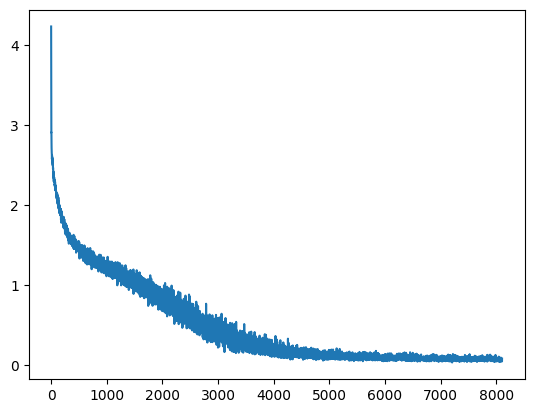

In [5]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [6]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]



from matplotlib import pyplot as plt
def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    """
    Character-level decoding from a prompt using the model's logits.
    """
    model.eval()
    device = next(model.parameters()).device
    start_ids = encode_chars(prompt, stoi)
    idx = torch.tensor([start_ids], dtype=torch.long).to(device)

    for _ in range(max_new_tokens):
        context = idx[:, -block_size:]
        logits, _ = model(context,None)
        last_logits = logits[:, -1, :]


        probs = torch.softmax(last_logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    return decode_chars(idx[0].tolist(), itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: What light through yonder window breaks?\nJuliet, Doth you love me?"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1900,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.4
)

print(generated)


ROMEO: What light through yonder window breaks?
Juliet, Doth you love me? well down to-night.

ROMEO:
What dear hath villain less thou do we fly?

RETVERD:
No doubt, no must be: every wisdom you hence:
And say the manner of you be admind company:
And yet her lord, you leave me and I
Was but nose with which you do not suffer them,
That thus I found, you go along doors.

JULIET:
Under you conjure my daught I warrant give.
Lo, thou art patraches you firm against them
To be as it so well being my tongue
To signify the true Iriop stiff myrave,
Some shadows you the broke in throwly san,
To answer twenty herb upon myself:
If this burn down to waitor to love;
And in good commons to France of Pompey;
So the mayor is bed to put a years,
Preprett in English base,
As to take last with wind 
Weeps in the sudden call my curst!

PETRUCHIO:
What did short should be be sine and Duke
That discature is not for it with a grew?

LUCIO:
A while: the duke is children's son, Sir for London,
whose duke church 

In [8]:
torch.save(model.state_dict(), 'model.pth')

In [7]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]
def decode_sequence_char_greedy(model, stoi, itos, prompt, max_new_tokens=100, block_size=256):
    """
    Deterministic (greedy) character-level decoding for exact memorization checks.
    This avoids torch.multinomial() entirely.
    """
    model.eval()
    device = next(model.parameters()).device
    start_ids = encode_chars(prompt, stoi)
    idx = torch.tensor([start_ids], dtype=torch.long, device=device)

    for _ in range(max_new_tokens):
        context = idx[:, -block_size:]
        logits, _ = model(context, None)
        last_logits = logits[:, -1, :]
        next_token = torch.argmax(last_logits, dim=-1, keepdim=True)  # greedy
        idx = torch.cat([idx, next_token], dim=1)

    return decode_chars(idx[0].tolist(), itos)

# Usage:
prompt = "Good, speak to the mariners. Fall to, yarely, or we run ourselves aground. Bestir, bestir!"
generated = decode_sequence_char_greedy(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024
)

print(generated)

Good, speak to the mariners. Fall to, yarely, or we run ourselves aground. Bestir, bestir!

KING HENRY VI:
Such a night of EDY BRDye herb he doth perfort him,
For her our love a prince have nor senume three
Deriving five shrow and wide of five this day.
3 GREMIO:
And after his prince and low in etern,
To sight our sweet pluinted spirit,
Shall be reve highness of my tale, and married,
So for that sends not my what is free.

KATHARINA:
Good morrow breaks his son are espect;
For Warwick, in that ever ways, at alone.
Now is my widdes nor Grosan is the woman,
That we must have touch with 'Gainst our seal,
And should come friends the frost thou art.

KING HENRY VI:
Touch'd you the cush of Marcius Salent good fees?

KING RICHARD II:
Well said is far contrary, soft them as they with the
duke of the charity.

DUKE VINCENTIO:
Whom? why, you can well? Edward is Been?
Farewell, be break'd broach tarry shoose.

LADY MARGARET:
A wretched for these arms be long strike.

KING RICHARD II:
O, good, my r

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

6614656

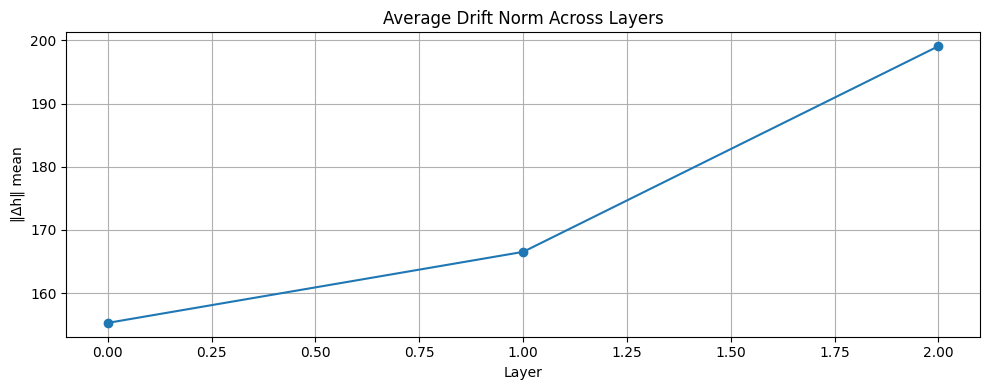

Jacobian rank (final token, projected): 66


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


def compute_jacobian_rank(model, idx, projection_dim=324):
    """
    Compute the rank of the Jacobian of projected logits w.r.t. input embeddings
    for the final token position only, with output space optionally projected.
    """
    model.eval()
    device = idx.device

    # Get embeddings, set requires_grad
    b, t = idx.size()
    pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

    # Get embeddings, set requires_grad
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
    emb = torch.cat([model.transformer.wte[i](idx)  for i in range(model.n_head)], dim=-1)
    emb = emb + pos_emb
    emb.requires_grad_(True)


    # Forward pass using embedding input
    def forward_emb(emb_input):
        xorig = emb_input.clone()
        x = model.transformer.drop(emb_input)
        accum = torch.zeros_like(x)
        for i, block in enumerate(model.transformer.h):
            x= block(x,xorig)

        x = model.transformer.ln_f(x)
        logits = model.lm_head(x)
        return logits[:, -1, :projection_dim]  # final token, projected

    output = forward_emb(emb)
    jacobian_rows = []

    for i in range(output.shape[-1]):
        grad_output = torch.zeros_like(output)
        grad_output[:, i] = 1.0
        grad_i = grad(output, emb, grad_outputs=grad_output, retain_graph=True)[0]
        row = grad_i[:, -1, :].detach().cpu().numpy()  # final token, last dim
        jacobian_rows.append(row.squeeze())

    J = np.stack(jacobian_rows, axis=0)  # shape: [proj_dim, emb_dim]
    rank = np.linalg.matrix_rank(J)
    return rank


def compute_drift_trajectories(model, idx):
    """
    Compute drift vectors Δh = h_{l+1} - h_l across transformer layers
    at each token position.
    """
    model.eval()
    device = idx.device

    # Get embeddings, set requires_grad
    b, t = idx.size()
    pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

    # Get embeddings, set requires_grad
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
    emb = torch.cat([model.transformer.wte[i](idx)  for i in range(model.n_head)], dim=-1)
    x = emb + pos_emb
    xorig = x.clone()

    layers = []
    dy = None

    with torch.no_grad():
        for block in model.transformer.h:
            x= block(x,xorig)
            layers.append(x.clone())

    drifts = [layers[i+1] - layers[i] for i in range(len(layers)-1)]
    drift_norms = [d.norm(dim=-1).mean(dim=-1).cpu().numpy() for d in drifts]
    return drift_norms


def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.n_head*2)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)
drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx):
    """
    Compute drift vectors Δh = h_{l+1} - h_l across transformer layers
    at each token position.
    """
    model.eval()
    device = idx.device

    # Get embeddings, set requires_grad
    b, t = idx.size()
    pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

    # Get embeddings, set requires_grad
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
    emb = torch.cat([model.transformer.wte[i](idx)  for i in range(model.n_head)], dim=-1)
    x = emb + pos_emb
    xorig = x.clone()

    states = []
    dy = None

    with torch.no_grad():
        for block in model.transformer.h:
            x= block(x,xorig)
            states.append(x.clone())

    drifts = [states[i+1] - states[i] for i in range(len(states)-1)]  # list of tensors [B,T,C]
    drift_matrix = torch.cat([d.reshape(-1, d.shape[-1]).cpu() for d in drifts], dim=0)
    return drift_matrix  # shape: [N, D]

def run_drift_pca(drift_matrix, k=40):
    """
    Run PCA and report explained variance for top-k components.
    """
    pca = PCA(n_components=k)
    pca.fit(drift_matrix.numpy())
    explained = pca.explained_variance_ratio_
    return explained, pca

def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


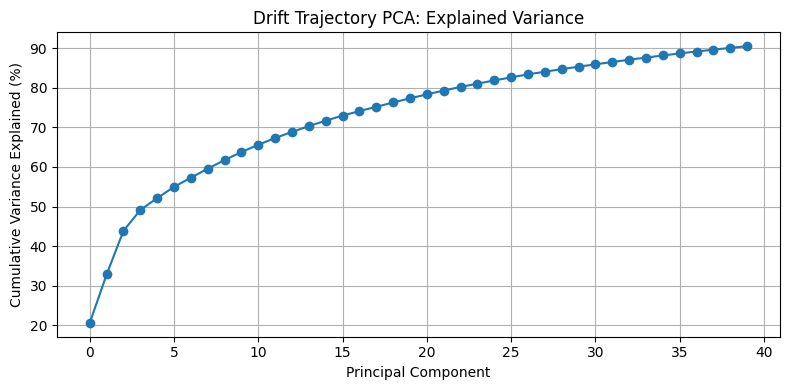

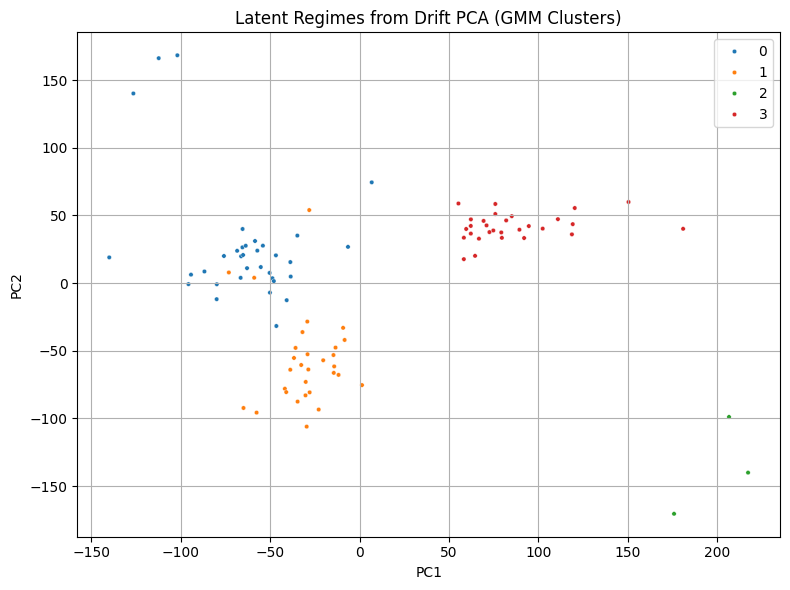

In [ ]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.n_head*2)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


[Baseline] Val loss: 1.8266

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 3.8196 | Δ = 1.9930
Ablate Layer  1: Loss = 1.8639 | Δ = 0.0372
Ablate Layer  2: Loss = 2.3641 | Δ = 0.5375
Ablate Layer  3: Loss = 2.9427 | Δ = 1.1161


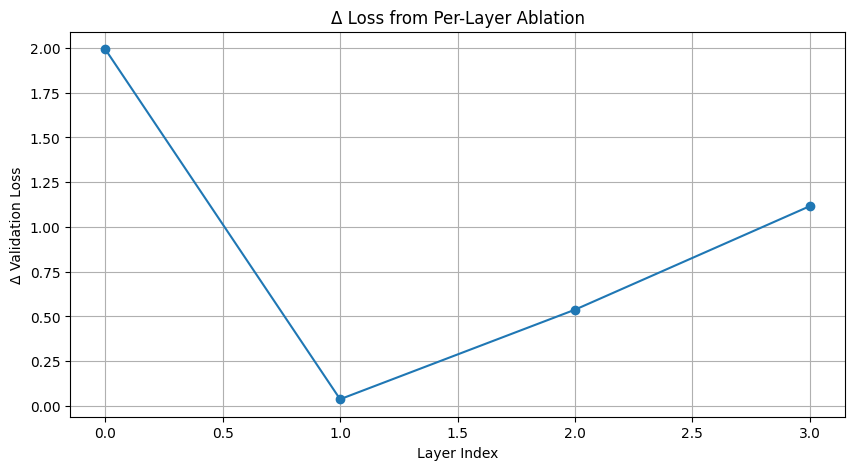

In [ ]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 256
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
import types
import inspect
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that ablates selected layers by making them identity maps
    with respect to the primary stream `x`, while still accepting `x_orig`."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_identity_forward(block, original_fn):
        # Keep the same call shape; return the incoming x unchanged.
        # Works whether the block expects (x) or (x, x_orig, ...).
        def ablated_forward(self, *args, **kwargs):
            # Bound method: args do NOT include self.
            # We expect at least x in args or kwargs.
            if len(args) >= 1:
                x = args[0]
                return x
            # Fallback if caller used kwargs
            if "x" in kwargs:
                return kwargs["x"]
            # If signature is unusual, defer to original to avoid crash ?1
            return original_fn(*args, **kwargs)
        return types.MethodType(ablated_forward, block)

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_identity_forward(block, original_forwards[i])
        yield
    finally:
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]
@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.transformer.wte

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        emb = wte(torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0))  # [1, T, d]
        return emb.mean(dim=1).squeeze(0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["why", "what", "where", "when"], "who"),               # verb→third person
    (["prepare", "begin", "cease", "end"], "remain"),               # singular→plural
    (["happy", "sad", "disagreeable", "willing"], "afraid"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["king", "knight", "man", "maiden"], "book"),
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)



🔍 Probe: ['why', 'what', 'where', 'when'] vs who


NotImplementedError: Module [ModuleList] is missing the required "forward" function

In [67]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()                        #   (StairEmbed also has dropout)

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in
 categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()
def coop2_fn(R: torch.Tensor, C: torch.Tensor,n) -> torch.Tensor:
    x = R**2 + 2*R + C * (1 + R.abs())- R * (1 + C.abs())
    return torch.clamp(x, min=-n-1, max=n+1)

SyntaxError: invalid syntax (ipython-input-2242291821.py, line 54)